In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from sklearn.manifold import TSNE
from tensorflow.keras.layers import Flatten, Input, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import random
import tensorflow as tf

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images / 255.
test_images = test_images / 255.

In [3]:
def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype('float32')

In [4]:
pairs_train, labels_train = make_pairs(train_images, train_labels)
pairs_test, labels_test = make_pairs(test_images, test_labels)

In [5]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, 1e-7))

In [6]:
input = Input(shape=(28, 28))
_ = Flatten()(input)
_ = Dense(128, activation='relu')(_)
_ = Dropout(0.1)(_)
_ = Dense(128, activation='relu')(_)
_ = Dropout(0.1)(_)
_ = Dense(128, activation='relu')(_)
base_model = Model(inputs=input, outputs=_)

base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512 

In [7]:
from tensorflow.keras.layers import Lambda
input_a = Input(shape=(28,28,), name='left_input')
vector_output_a = base_model(input_a)
input_b = Input(shape=(28,28,), name='right_input')
vector_output_b = base_model(input_b)
output = Lambda(euclidean_distance, name='output_layer')([vector_output_a, vector_output_b])
model = Model([input_a, input_b], output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 28, 28)]     0           []                               
                                                                                                  
 right_input (InputLayer)       [(None, 28, 28)]     0           []                               
                                                                                                  
 model (Functional)             (None, 128)          133504      ['left_input[0][0]',             
                                                                  'right_input[0][0]']            
                                                                                                  
 output_layer (Lambda)          (None, 1)            0           ['model[0][0]',            

In [8]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
        return tf.math.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss
 
rms = tf.keras.optimizers.RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train, epochs=20, batch_size=128, validation_data=([pairs_test[:,0], pairs_test[:,1]], labels_test))

Epoch 1/20
938/938 [==============================] - 13s 11ms/step - loss: 0.1101 - val_loss: 0.0840
Epoch 2/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0789 - val_loss: 0.0769
Epoch 3/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0702 - val_loss: 0.0697
Epoch 4/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0654 - val_loss: 0.0697
Epoch 5/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0628 - val_loss: 0.0663
Epoch 6/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0603 - val_loss: 0.0670
Epoch 7/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0587 - val_loss: 0.0681
Epoch 8/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0577 - val_loss: 0.0684
Epoch 9/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0565 - val_loss: 0.0644
Epoch 10/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0552 - val_loss: 0.06

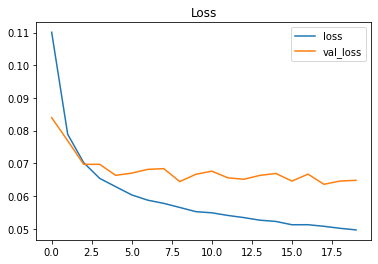

In [9]:
plt.title('Loss')
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_' + 'loss'],label='val_' + 'loss')
plt.legend()

In [10]:
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red')
        if predictions[i] < 0.2: t.set_color('green')
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

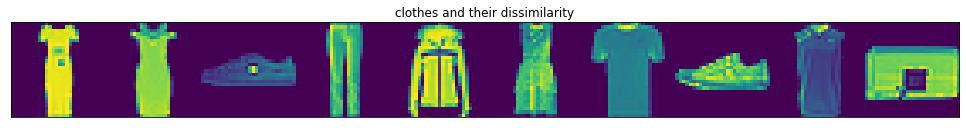

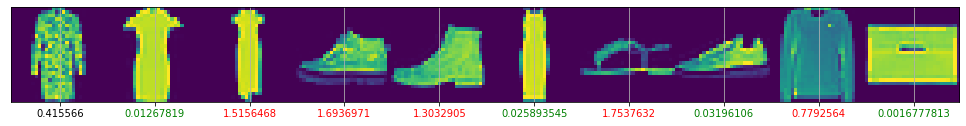

In [11]:
predictions = np.squeeze(model.predict([pairs_test[:,0], pairs_test[:,1]]))
indexes = np.random.choice(len(predictions), size=10)

display_images(pairs_test[:, 0][indexes], pairs_test[:, 1][indexes], predictions[indexes], labels_test[indexes], "clothes and their dissimilarity", 10)